In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Imports

In [8]:
import os
import warnings
import pickle
import pysam
import numpy as np
from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *
from keras.models import load_model
from concise.metrics import tpr, tnr, fpr, fnr, precision, f1
from keras.models import load_model
from kerasAC.metrics import recall, specificity, fpr, fnr, precision, f1
from kerasAC.custom_losses import ambig_binary_crossentropy, ambig_mean_squared_error

## Select GPU

In [9]:
warnings.filterwarnings('ignore')
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
!env | grep "CUDA"

CUDA_VISIBLE_DEVICES=0
CUDA_HOME=/usr/local/cuda-10.0


## Get Models


In [10]:
custom_objects={"recall":recall,
                "sensitivity":recall,
                "specificity":specificity,
                "fpr":fpr,
                "fnr":fnr,
                "precision":precision,
                "f1":f1,
                "ambig_binary_crossentropy":ambig_binary_crossentropy,
                "ambig_mean_squared_error":ambig_mean_squared_error}


In [11]:
regression_model_string_gc="DNASE.K562.regressionlabels.7.withgc"
regression_model_gc=load_model(regression_model_string_gc,custom_objects=custom_objects)
classification_model_string_gc="DNASE.K562.classificationlabels.7.withgc"
classification_model_gc=load_model(classification_model_string_gc,custom_objects=custom_objects)


W1022 11:55:22.584086 140363568817920 deprecation_wrapper.py:119] From /users/annashch/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1022 11:55:22.590730 140363568817920 deprecation_wrapper.py:119] From /users/annashch/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1022 11:55:22.614160 140363568817920 deprecation_wrapper.py:119] From /users/annashch/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1022 11:55:22.614975 140363568817920 deprecation_wrapper.py:119] From /users/annashch/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.

In [12]:
#regression_model_gc.summary()
#classification_model_gc.summary()

## Iterate through the loci  

In [13]:
import pandas as pd
def get_seq_centered_at_summit(fname,flank):
    data=pd.read_csv(fname,header=None,sep='\t')
    data['chrom']=data[0]
    data['center']=[int(round(i)) for i in 0.5*(data[1]+data[2])]
    data['start']=data['center']-flank
    data['end']=data['center']+flank
    subset=data[['chrom','start','end']]
    inputs=[]
    for index,row in subset.iterrows(): 
        inputs.append((row['chrom'],row['start'],row['end']))
    return inputs

In [14]:
from dragonn.utils import * 
import pandas as pd 
flank=500
ref_fasta="/users/annashch/male.hg19.fa"

In [15]:
from keras import backend as K
reg_target_layer_idx=-1
reg_fn_gc = K.function(regression_model_gc.inputs, K.gradients(regression_model_gc.layers[reg_target_layer_idx].output, regression_model_gc.inputs))

clas_target_layer_idx=-2
class_fn_gc=K.function(classification_model_gc.inputs, K.gradients(classification_model_gc.layers[clas_target_layer_idx].output, classification_model_gc.inputs))

In [17]:
loci=["BCL11A","HBA2","HBE1","LMO2","MYC","RBM38"]
for locus in loci:
    gc_content=open("../compute_gc/gc."+locus+".bed",'r').read().strip().split('\n')
    gc_vals=np.expand_dims(np.asarray([float(i.split('\t')[-1]) for i in gc_content]),axis=1)
    bed=get_seq_centered_at_summit("../coordinates/Gurkan_hg19_loci_coords/"+locus+".geneLocus.250bp.windows.hg19.bed",flank)
    onehot_seq=one_hot_from_bed(bed,ref_fasta)
    print(onehot_seq.shape)
    num_entries=onehot_seq.shape[0]
    all_reg_grads=[]
    all_class_grads=[] 
    for i in range(0,num_entries,1000):
        reg_grads_gc=reg_fn_gc([onehot_seq[i:i+1000],gc_vals[i:i+1000]])[0] #only w/respect to sequence input 
        all_reg_grads.append(reg_grads_gc)
        clas_grads_gc=class_fn_gc([onehot_seq[i:i+1000],gc_vals[i:i+1000]])[0]
        all_class_grads.append(clas_grads_gc)
    reg_grads_gc=reg_fn_gc([onehot_seq[i:num_entries],gc_vals[i:num_entries]])[0] #only w/respect to sequence input 
    all_reg_grads.append(reg_grads_gc)
    clas_grads_gc=class_fn_gc([onehot_seq[i:num_entries],gc_vals[i:num_entries]])[0]
    all_class_grads.append(clas_grads_gc)
    all_reg_grads=np.asarray(all_reg_grads)
    all_class_grads=np.asarray(all_class_grads)
    np.savez_compressed(locus+".regression.grads.gc.corrected.npz",grads=all_reg_grads)
    np.savez_compressed(locus+".classification.grads.gc.corrected.npz",grads=all_class_grads)
    print("processed locus:"+str(locus))    

(8001, 1, 1000, 4)
processed locus:HBE1
(8001, 1, 1000, 4)
processed locus:LMO2
(8001, 1, 1000, 4)
processed locus:MYC
(8001, 1, 1000, 4)
processed locus:RBM38


In [67]:
bcl11a_grads=np.load("BCL11A.regression.grads.gc.corrected.npz",allow_pickle=True)
tmp=np.concatenate(bcl11a_grads['grads'],axis=0)
tmp.shape


(8002, 1, 1000, 4)

In [91]:
regions=[ 6939,
 7544,
 7545,
 7627,
 7628,
 7668,
 7669,
 7670,
 7671,
 7672,
 7673,
 7933,
 7934,
 7935,
 7938,
 7939,
 7940,
 7941,
 7942]
subset=tmp[regions]

In [92]:
bed=get_seq_centered_at_summit("../coordinates/Gurkan_hg19_loci_coords/"+"BCL11A"+".geneLocus.250bp.windows.hg19.bed",flank)
subset_bed=[bed[i] for i in regions]

In [93]:
from dragonn.utils import * 

In [94]:
subset_onehot=one_hot_from_bed(subset_bed,ref_fasta="/users/annashch/male.hg19.fa")

In [95]:
from dragonn.vis import * 

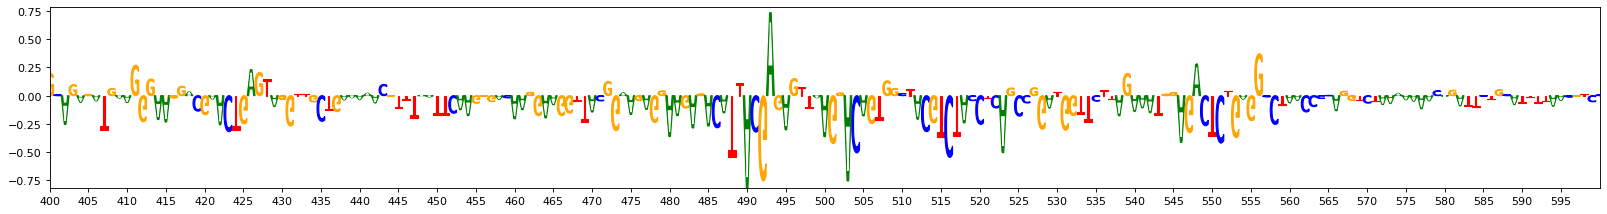

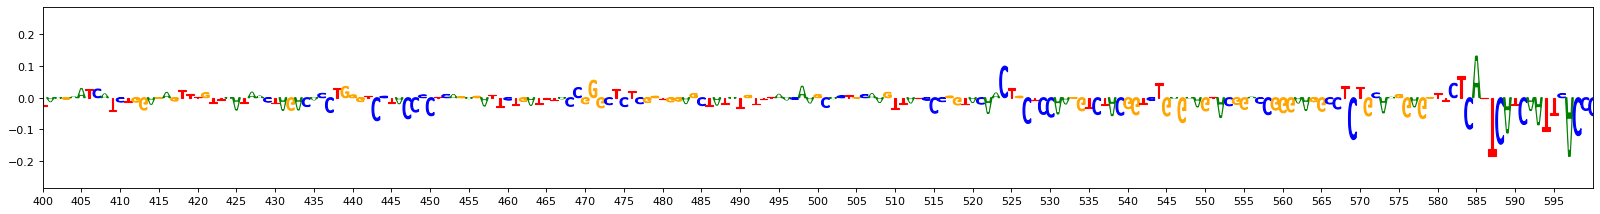

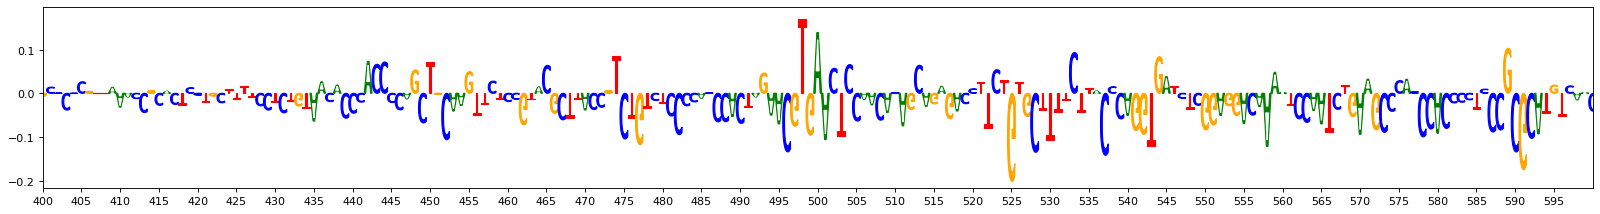

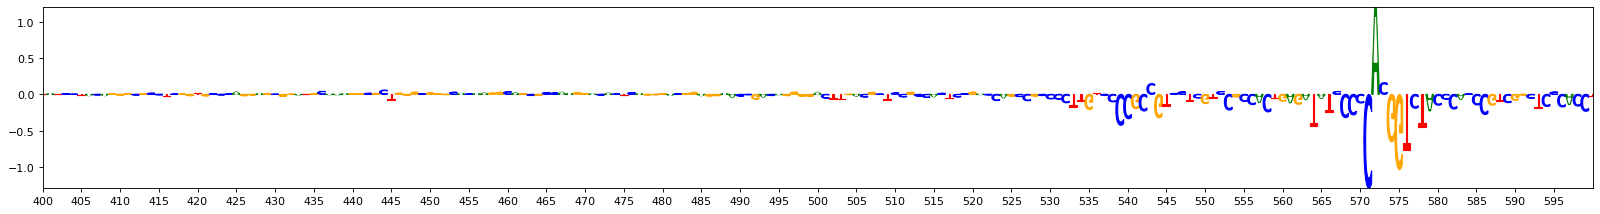

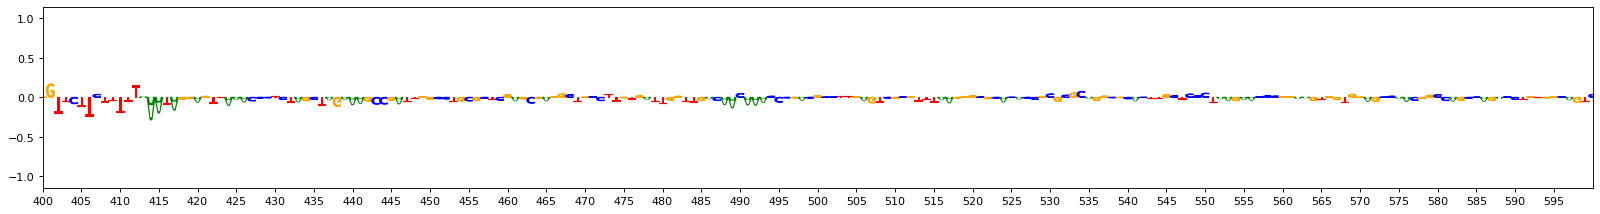

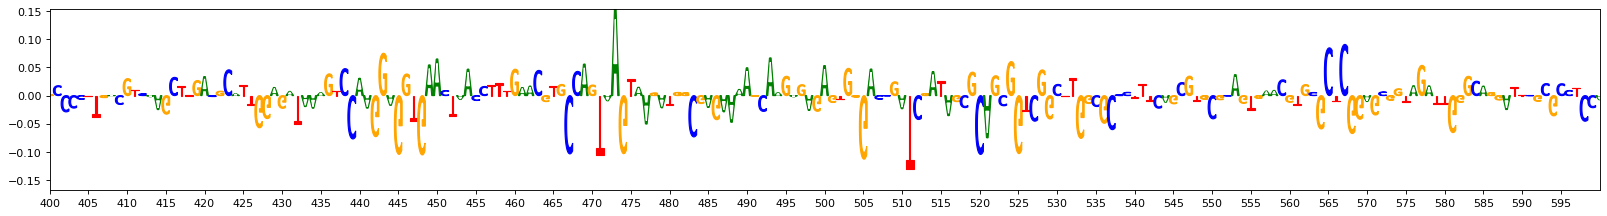

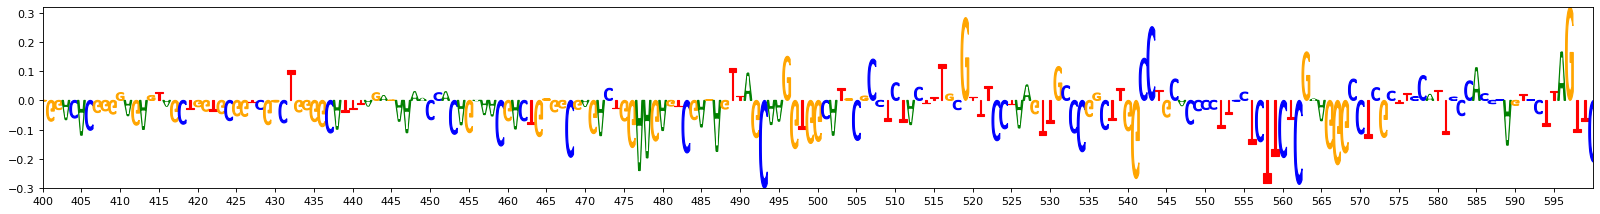

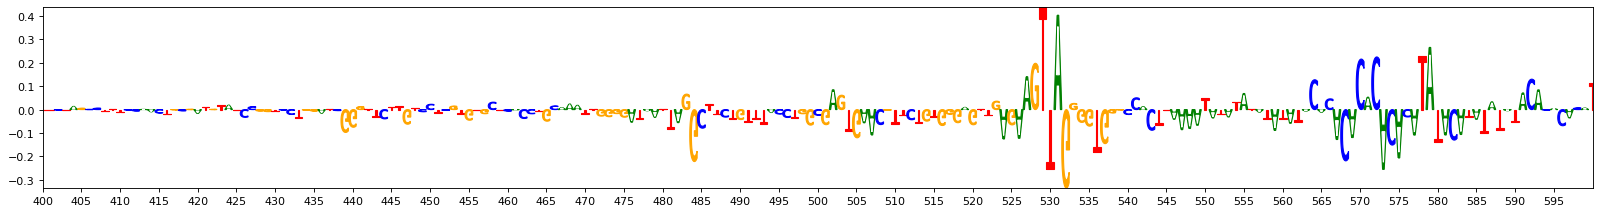

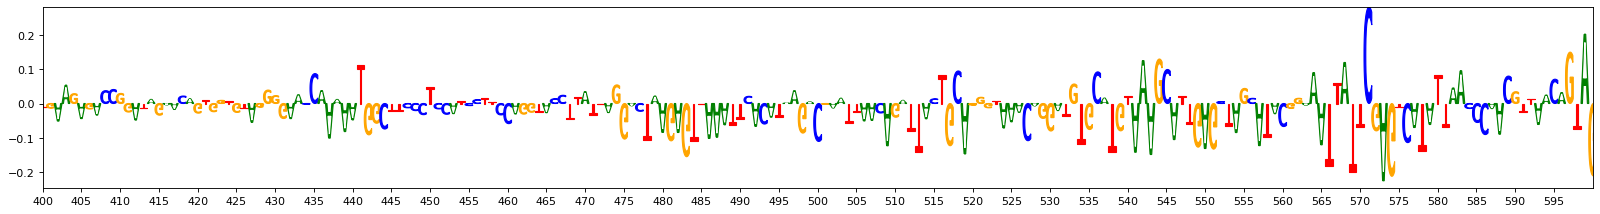

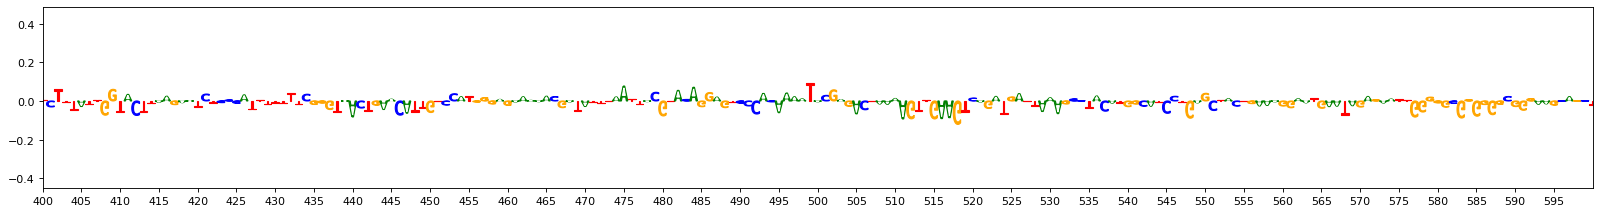

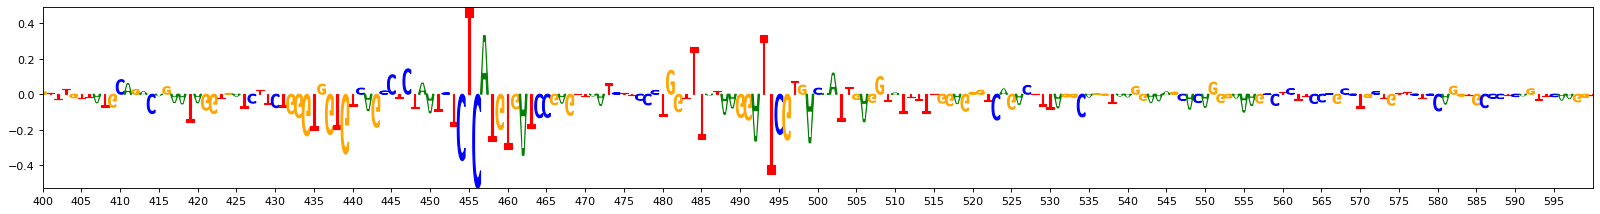

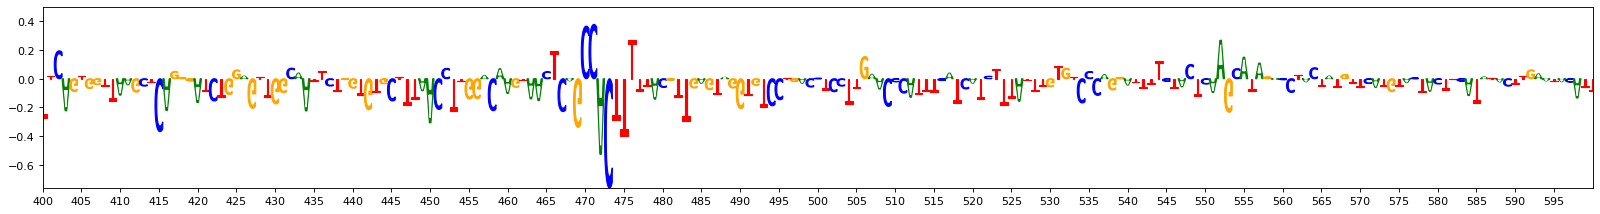

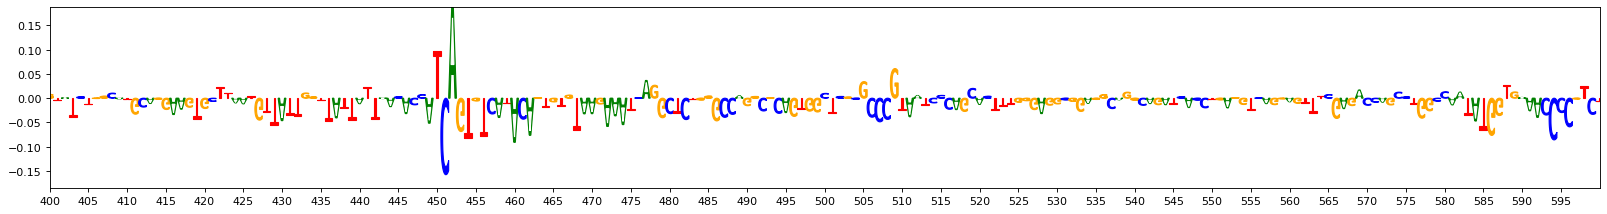

In [96]:
for i in range(13): 
    plot_seq_importance(subset[i],onehot_seq[i],xlim=(400,600))